In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from textwrap import wrap
from matplotlib.font_manager import FontProperties
import re
from scipy import stats
from matplotlib.lines import Line2D 
import os

line_size=0.5
custom_params = {
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'axes.axisbelow': 'line',
    'axes.labelcolor': 'black',
    'figure.facecolor': 'white',
    "axes.spines.right": True, 
    "axes.spines.bottom": True,
    'xtick.direction': 'inout',
    'ytick.direction': 'in',
    'xtick.bottom': True,
    'xtick.minor.visible': False,
    'xtick.major.bottom':  True,
    'xtick.minor.bottom':  True,
    'xtick.major.pad':     7,     # distance to major tick label in points#
    'xtick.minor.pad':     3.4,     # distance to the minor tick label in points#
    'xtick.major.size':    10,
    'ytick.major.size':    4,
    'xtick.major.width':   line_size,
    'ytick.major.width':   line_size,
    'axes.linewidth': line_size,
    'xtick.minor.size':    2,
    'pdf.fonttype': 42}

sns.set_theme(style="ticks", rc=custom_params, font="Arial",font_scale=0.7)

enmax_palette = ["#648FFF", "#FE6100", "#785EF0", "#DC267F", "#FFB000"]
sns.set_palette(palette=enmax_palette)

In [2]:
input_dir = r'Figure_Data'
output_dir = r'Figure_Export'

In [3]:
df = pd.read_csv(f'{input_dir}/Off-Target_Proteomics.csv') 

df['Sample'] = df['Sample'].astype(str)
df['Protein.Group'] = df['Protein.Group'].astype(str)

df['Sample'] = df['Sample'].str.replace(r'^JBEI_OTS_|_48hr$', '', regex=True)
df['Sample'] = df['Sample'].str.replace(r'^JBEI_', '', regex=True)
df['Sample'] = df['Sample'].str.replace(r'|_P4', '', regex=True)
df['Sample'] = df['Sample'].replace('PP_0977', 'PP_0977_3')

In [4]:
name_df = pd.read_csv(f'{input_dir}/proteomics_id_translator_240305.csv') 
translator_dict = pd.Series(name_df['locus'].values, index=name_df['extracted']).to_dict()

def map_protein_group(protein_group):
    return translator_dict.get(protein_group, protein_group)  # Return the original if not found

df['Protein.Group'] = df['Protein.Group'].map(map_protein_group)

nontranslated = df['Protein.Group'].apply(lambda x: x not in translator_dict.values()).sum()
print(f"In total, N = {nontranslated}/{len(df['Protein.Group'])} proteins were not translated to primary/locus names")

df.to_csv(f'{output_dir}/translated.csv', index=False)

In total, N = 2340/90180 proteins were not translated to primary/locus names


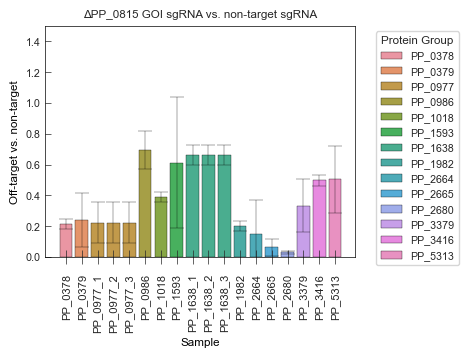

In [5]:
analysis_name = 'PP_0815_Off_Target'

# Filter for the control and other samples
control_df = df[df['Sample'] == 'PP_0815_NT']
other_samples_df = df[df['Sample'] != 'PP_0815_NT']

# Ensure the Protein.Group and Sample columns are comparable
other_samples_df = other_samples_df.dropna(subset=['Protein.Group', 'Sample'])
other_samples_df = other_samples_df[other_samples_df.apply(lambda row: row['Protein.Group'] in row['Sample'], axis=1)]

# Aggregate data to get mean and standard deviation for each Protein.Group within each Sample
control_stats = control_df.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].agg(['mean', 'std']).reset_index()
control_stats.rename(columns={'mean': 'Control_Mean', 'std': 'Control_Std'}, inplace=True)

sample_stats = other_samples_df.groupby(['Sample', 'Protein.Group'])['%_of protein_abundance_Top3-method'].agg(['mean', 'std']).reset_index()

# Merge sample stats with control stats
merged_df = sample_stats.merge(control_stats, on='Protein.Group', how='left')
merged_df['Ratio'] = merged_df['mean'] / merged_df['Control_Mean']
merged_df['Ratio_Std'] = merged_df['Ratio'] * ((merged_df['std'] / merged_df['mean'])**2 + (merged_df['Control_Std'] / merged_df['Control_Mean'])**2)**0.5
target_df = df[df['Sample'] == 'PP_0815_Target']

# Aggregate data to get mean and standard deviation for PP_0815_Target samples
target_stats = target_df.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].agg(['mean', 'std']).reset_index()
target_stats.rename(columns={'mean': 'Target_Mean', 'std': 'Target_Std'}, inplace=True)

# Merge target stats with the existing merged_df
merged_df = merged_df.merge(target_stats, on='Protein.Group', how='left')

# Calculate the target ratio and its standard deviation
merged_df['Target_Ratio'] = merged_df['Target_Mean'] / merged_df['Control_Mean']
merged_df['Target_Ratio_Std'] = merged_df['Target_Ratio'] * ((merged_df['Target_Std'] / merged_df['Target_Mean'])**2 + (merged_df['Control_Std'] / merged_df['Control_Mean'])**2)**0.5

# Create the bar plot
plt.figure(figsize=(4, 3))

# Add bars for the target/control ratio
sns.barplot(data=merged_df, x='Sample', y='Target_Ratio', hue='Protein.Group', dodge=False, edgecolor='black', linewidth=0.25)

# Add error bars for the target/control ratio
for i, row in merged_df.iterrows():
    plt.errorbar(x=i, y=row['Target_Ratio'], yerr=row['Target_Ratio_Std'], fmt='none', c='black', capsize=5, linewidth=0.25, capthick=0.25)

plt.title('ΔPP_0815 GOI sgRNA vs. non-target sgRNA')
plt.xticks(rotation=90, fontsize=8)  # Set the font size for x-axis labels
plt.xlabel('Sample')
plt.ylabel('Off-target vs. non-target')
plt.ylim(0, 1.5)
plt.legend(title='Protein Group', bbox_to_anchor=(1.05, 1), loc='upper left')

output_file = os.path.join(output_dir, f'{analysis_name}.pdf')
plt.savefig(output_file, dpi=400, bbox_inches='tight')
plt.show()

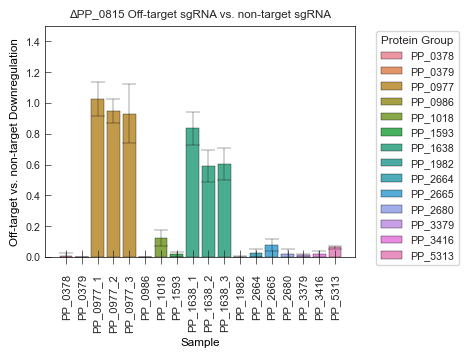

In [6]:
analysis_name = 'OT_Screen'
# Filter for the control and other samples
control_df = df[df['Sample'] == 'PP_0815_NT']
other_samples_df = df[df['Sample'] != 'PP_0815_NT']

# Ensure the Protein.Group and Sample columns are comparable
other_samples_df = other_samples_df.dropna(subset=['Protein.Group', 'Sample'])
other_samples_df = other_samples_df[other_samples_df.apply(lambda row: row['Protein.Group'] in row['Sample'], axis=1)]

# Aggregate data to get mean and standard deviation for each Protein.Group within each Sample
control_stats = control_df.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].agg(['mean', 'std']).reset_index()
control_stats.rename(columns={'mean': 'Control_Mean', 'std': 'Control_Std'}, inplace=True)

sample_stats = other_samples_df.groupby(['Sample', 'Protein.Group'])['%_of protein_abundance_Top3-method'].agg(['mean', 'std']).reset_index()

# Merge sample stats with control stats
merged_df = sample_stats.merge(control_stats, on='Protein.Group', how='left')

# Calculate the ratio and its standard deviation
merged_df['Ratio'] = merged_df['mean'] / merged_df['Control_Mean']
merged_df['Ratio_Std'] = merged_df['Ratio'] * ((merged_df['std'] / merged_df['mean'])**2 + (merged_df['Control_Std'] / merged_df['Control_Mean'])**2)**0.5

# Filter for the PP_0815_Target samples
target_df = df[df['Sample'] == 'PP_0815_Target']

# Aggregate data to get mean and standard deviation for PP_0815_Target samples
target_stats = target_df.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].agg(['mean', 'std']).reset_index()
target_stats.rename(columns={'mean': 'Target_Mean', 'std': 'Target_Std'}, inplace=True)

# Merge target stats with the existing merged_df
merged_df = merged_df.merge(target_stats, on='Protein.Group', how='left')

# Calculate the target ratio and its standard deviation
merged_df['Target_Ratio'] = merged_df['Target_Mean'] / merged_df['Control_Mean']
merged_df['Target_Ratio_Std'] = merged_df['Target_Ratio'] * ((merged_df['Target_Std'] / merged_df['Target_Mean'])**2 + (merged_df['Control_Std'] / merged_df['Control_Mean'])**2)**0.5

# Create the bar plot
plt.figure(figsize=(4,3))
sns.barplot(data=merged_df, x='Sample', y='Ratio', hue='Protein.Group', dodge=False, edgecolor='black', linewidth=0.25)

# Add error bars for the sample/control ratio
for i, row in merged_df.iterrows():
    plt.errorbar(x=i, y=row['Ratio'], yerr=row['Ratio_Std'], fmt='none', c='black', capsize=5, linewidth=0.25, capthick=0.25)

plt.title('ΔPP_0815 Off-target sgRNA vs. non-target sgRNA')
plt.xticks(rotation=90, fontsize=8)  # Set the font size for x-axis labels
plt.xlabel('Sample')
plt.ylabel('Off-target vs. non-target Downregulation')
plt.ylim(0, 1.5)
plt.legend(title='Protein Group', bbox_to_anchor=(1.05, 1), loc='upper left')

output_file = os.path.join(output_dir, f'{analysis_name}.pdf')
plt.savefig(output_file, dpi=400, bbox_inches='tight')
plt.show()

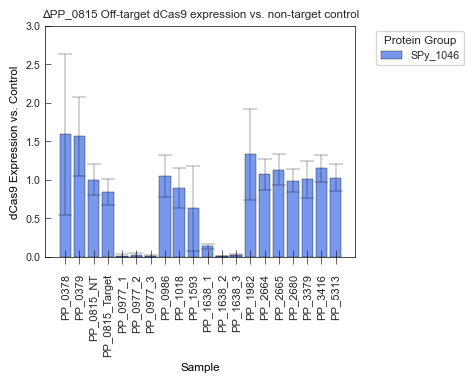

In [7]:
analysis_name = 'dCas9_Expression'

# Filter for the control and other samples
control_df = df[df['Sample'] == 'PP_0815_NT']
other_samples_df = df[df['Sample'] != 'PP_0815_NT']

# Filter the DataFrame to include only dCas9 expression data
dcas9_df = df[df['Protein.Group'] == 'SPy_1046']

# Aggregate data to get mean and standard deviation for dCas9 expression
control_dcas9_stats = control_df[control_df['Protein.Group'] == 'SPy_1046'].groupby('Protein.Group')['%_of protein_abundance_Top3-method'].agg(['mean', 'std']).reset_index()
control_dcas9_stats.rename(columns={'mean': 'Control_Mean', 'std': 'Control_Std'}, inplace=True)

sample_dcas9_stats = dcas9_df.groupby(['Sample', 'Protein.Group'])['%_of protein_abundance_Top3-method'].agg(['mean', 'std']).reset_index()

# Merge sample stats with control stats
merged_dcas9_df = sample_dcas9_stats.merge(control_dcas9_stats, on='Protein.Group', how='left')

# Calculate the ratio and its standard deviation
merged_dcas9_df['Ratio'] = merged_dcas9_df['mean'] / merged_dcas9_df['Control_Mean']
merged_dcas9_df['Ratio_Std'] = merged_dcas9_df['Ratio'] * ((merged_dcas9_df['std'] / merged_dcas9_df['mean'])**2 + (merged_dcas9_df['Control_Std'] / merged_dcas9_df['Control_Mean'])**2)**0.5

merged_dcas9_df = merged_dcas9_df.sort_values(by='Sample')
# Create the bar plot
plt.figure(figsize=(4,3))

# Plot the dCas9 expression ratio
sns.barplot(data=merged_dcas9_df, x='Sample', y='Ratio', hue='Protein.Group', dodge=False, palette=['#648FFF'], edgecolor='black', linewidth=0.25)

# Add error bars for the dCas9 expression ratio
for i, row in merged_dcas9_df.iterrows():
    plt.errorbar(x=i, y=row['Ratio'], yerr=row['Ratio_Std'], fmt='none', c='black', capsize=5, linewidth=0.25, capthick=0.25)

plt.title('ΔPP_0815 Off-target dCas9 expression vs. non-target control')
plt.xticks(rotation=90, fontsize=8)  # Set the font size for x-axis labels
plt.xlabel('Sample')
plt.ylabel('dCas9 Expression vs. Control')
plt.ylim(0, 3)
plt.legend(title='Protein Group', bbox_to_anchor=(1.05, 1), loc='upper left')

output_file = os.path.join(output_dir, f'{analysis_name}.pdf')
plt.savefig(output_file, dpi=400, bbox_inches='tight')
plt.show()

C:\Users\Carruthers\AppData\Local\Temp\ipykernel_26248\4268988886.py:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(
C:\Users\Carruthers\AppData\Local\Temp\ipykernel_26248\4268988886.py:8: UserWarning: 
The palette list has fewer values (1) than needed (20) and will cycle, which may produce an uninterpretable plot.
  ax = sns.stripplot(
C:\Users\Carruthers\AppData\Local\Temp\ipykernel_26248\4268988886.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Protein Group', bbox_to_anchor=(1.05, 1), loc='upper left')


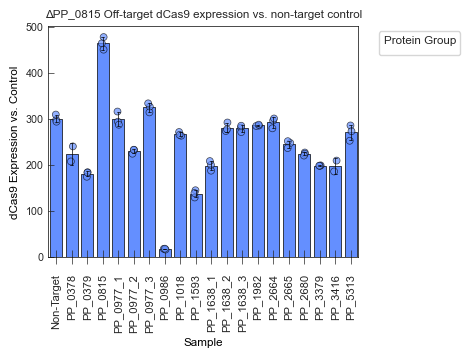

In [8]:
analysis_name = 'Off-target_Isoprenol'

df = pd.read_csv(f'{input_dir}/Off-target_Isoprenol.csv')
df['Sample'] = df['Sample'].replace('Target', 'PP_0815')
df = df.sort_values(by='Sample')
plt.figure(figsize=(4,3))

ax = sns.stripplot(
    data=df, x="Sample", 
    y="titer",
    dodge=False, alpha=0.7, linewidth=line_size, edgecolor="0", zorder=2,palette=['#648FFF'])

ax = sns.barplot(
    data=df, x="Sample", y="titer",
    errorbar="sd", zorder=0, capsize=0.2, errcolor="0", errwidth=line_size,
    linewidth=line_size, edgecolor="0", saturation=1,palette=['#648FFF'])

legend_handles, labels = ax.get_legend_handles_labels()

plt.title('ΔPP_0815 Off-target dCas9 expression vs. non-target control')
plt.xticks(rotation=90, fontsize=8)  # Set the font size for x-axis labels
plt.xlabel('Sample')
plt.ylabel('dCas9 Expression vs. Control')
plt.ylim(0,)
plt.legend(title='Protein Group', bbox_to_anchor=(1.05, 1), loc='upper left')

output_file = os.path.join(output_dir, f'{analysis_name}.pdf')
plt.savefig(output_file, dpi=400, bbox_inches='tight')
plt.show()